# Does NYC Metro Region have a home-job balance?

MUSA 550 - Fall 2023

Yinan Li, Jingyi Cai, Shuting Li

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import hvplot.pandas

np.random.seed(42)

In [4]:
pd.options.display.max_columns = 999

## 1. Data Preprocessing

#### Geographic Boundary

In [12]:
from IPython.display import Image, display, HTML

# Path to your image file
image_path = 'Pic/County_boundary/map.png'

# Set the width and height you want
width = 800
height = 600

# Display the image with specified width and height
display(HTML(f'<img src="{image_path}" width="{width}" height="{height}">'))

**NYC 5 boroughs:**
- Manhattan: New York County, New York
- Brooklyn: Kings County, New York
- Bronx: Bronx County, New York
- Queens: Queens County, New York
- Staten Island: Richmond County, New York

**Outside NYC counties:**
- Jersey City: Hudson County, New Jersey
- Long Island: Nassau County, New York

**Geographical level:** by census tract

In [36]:
# We have processed the geographical data
# You can load the NYC Metro Region geographical data on census tract directly
nycmetro_geojson_path = 'Data/Geo/nyc_metro.geojson'
nyc_metro_gdf = gpd.read_file(nycmetro_geojson_path).to_crs(epsg=2263)

In [56]:
len(nyc_metro_gdf)

2678

C:\Users\DELL\AppData\Local\Temp\ipykernel_18880\1753084468.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


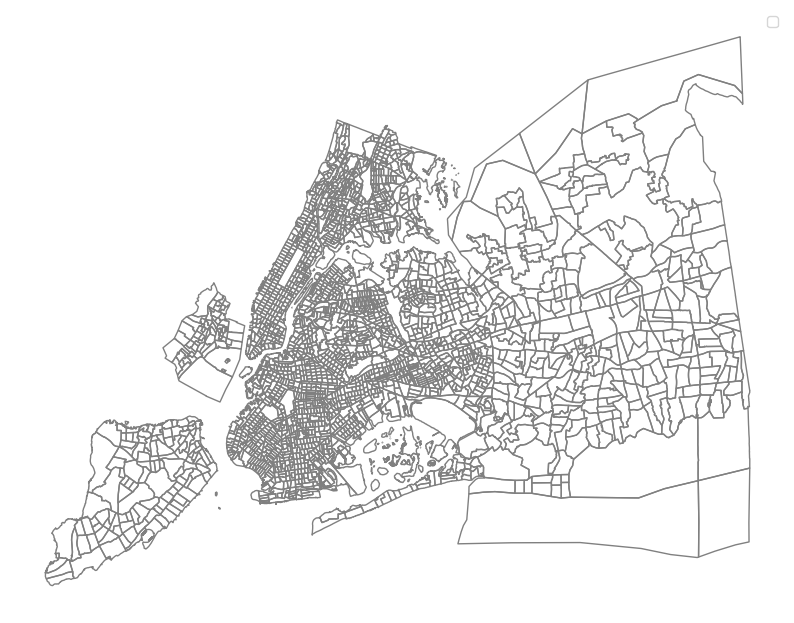

In [34]:
# Map the NYC Metro Region
ax = plt.figure(figsize=(10, 10)).add_subplot(111)

# Plot the census tracts layer on the same plot
nyc_metro_gdf.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=1, label='Census Tracts')

# Remove axis
ax.axis('off')

# Add legend
ax.legend()

#### LODES Data

In [38]:
# Path to your image file
image_path = 'Pic/LODES_Directory.png'

# Set the width and height you want
width = 600
height = 600

# Display the image with specified width and height
display(HTML(f'<img src="{image_path}" width="{width}" height="{height}">'))

In [117]:
# We have processed the LODES data to the population who worked in NYC
# You can download the dataset from here to your LODES folder under 'Data':


# You can load them directly
PATH = 'Data/LODES/'
OD_main_2021 = pd.read_csv(PATH  + 'NYC_MAIN_2021.csv')
OD_main_2019 = pd.read_csv(PATH  + 'NYC_MAIN_2019.csv')
OD_aux_2021 = pd.read_csv(PATH  + 'NYC_AUX_2021.csv')
OD_aux_2019 = pd.read_csv(PATH  + 'NYC_AUX_2019.csv')

In [118]:
OD_main_2021.head()

,w_geocode_ct,h_geocode_ct,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,w_geocode_ct_n
0,36005000100,36001000100,1,0,1,0,0,0,1,0,0,1,36005000100
1,36005000100,36001000201,1,0,1,0,0,0,1,0,0,1,36005000100
2,36005000100,36001013602,1,0,1,0,0,0,1,0,0,1,36005000100
3,36005000100,36001013706,1,1,0,0,0,0,1,0,0,1,36005000100
4,36005000100,36001014303,1,0,1,0,1,0,0,0,0,1,36005000100


In [119]:
print(len(OD_main_2021), len(OD_aux_2021), len(OD_main_2019), len(OD_aux_2019))

1280160 0 1338377 298182


**Insight:**
- In 2021, there are 128k rows of OD data for people who worked in NYC
- In 2019, there are 164k rows of OD data for people who worked in NYC

### 1.1 Geospatial Data Processing

In [7]:
# Load the NYC census tract GeoJSON
nycct_url = "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson"

# Load the GeoJSON data directly from the URL into a GeoDataFrame
nyc_gdf = gpd.read_file(nycct_url).to_crs(epsg=2263)

In [14]:
# Load the Hudson County, New Jersey GeoJSON data
hudson_file_path = 'Data/Geo/hudson_census-tracts-2020.geojson'

# Load the GeoJSON file
hudson_gdf = gpd.read_file(hudson_file_path).to_crs(epsg=2263)

In [17]:
# Load New York State shapefile
nys_shp = 'Data/Geo/ny_state_tract2020/tl_2020_36_tract.shp'

# Read the shapefile
nys_shp = gpd.read_file(nys_shp).to_crs(epsg=2263)

# Convert shapefile to geojson
nys_geojson_path = 'Data/Geo/nys_ct_2020.geojson'

# Write the GeoDataFrame to GeoJSON
nys_shp.to_file(nys_geojson_path, driver='GeoJSON')

In [18]:
# Load the New York State GeoJSON file
nys_gdf = gpd.read_file(nys_geojson_path).to_crs(epsg=2263)

In [20]:
nys_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,047,000700,36047000700,7,Census Tract 7,G5020,S,176774,0,+40.6923505,-073.9973434,"POLYGON ((983822.387 191677.069, 983884.784 19..."
1,36,047,000900,36047000900,9,Census Tract 9,G5020,S,163469,0,+40.6917206,-073.9916018,"POLYGON ((985901.155 190988.903, 985987.108 19..."
2,36,047,001100,36047001100,11,Census Tract 11,G5020,S,168507,0,+40.6932903,-073.9877087,"POLYGON ((986821.216 191772.656, 986899.113 19..."
3,36,047,001300,36047001300,13,Census Tract 13,G5020,S,293167,0,+40.6976150,-073.9883586,"POLYGON ((986632.168 193807.053, 986660.709 19..."
4,36,047,002000,36047002000,20,Census Tract 20,G5020,S,154138,0,+40.6480407,-074.0159276,"POLYGON ((979067.973 175146.581, 979229.520 17..."


In [21]:
len(nys_gdf)

5411

In [27]:
# Trim Nassau County, New York
nassau_gdf = nys_gdf[nys_gdf['COUNTYFP'] == '059']

In [28]:
nassau_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
89,36,059,413500,36059413500,4135,Census Tract 4135,G5020,S,2000605,0,+40.6693203,-073.6107541,"POLYGON ((1088641.212 183101.292, 1088796.074 ..."
90,36,059,413600,36059413600,4136,Census Tract 4136,G5020,S,1849986,22581,+40.6576037,-073.6111953,"POLYGON ((1089024.132 179090.922, 1089312.438 ..."
91,36,059,413700,36059413700,4137,Census Tract 4137,G5020,S,1817573,39370,+40.6465468,-073.6098142,"POLYGON ((1089868.091 177639.436, 1089916.079 ..."
92,36,059,413803,36059413803,4138.03,Census Tract 4138.03,G5020,S,1805280,448675,+40.6273483,-073.6078072,"POLYGON ((1090551.007 171472.835, 1090571.190 ..."
93,36,059,413804,36059413804,4138.04,Census Tract 4138.04,G5020,S,1192867,1008410,+40.6280022,-073.5969078,"POLYGON ((1093867.202 172751.424, 1093906.013 ..."


In [33]:
# Merge these 3 dataframes together
nyc_metro_df = pd.concat([nyc_gdf, hudson_gdf, nassau_gdf], ignore_index=True)

# Convert to geodataframe
nyc_metro_gdf = gpd.GeoDataFrame(nyc_metro_df, geometry='geometry')

In [35]:
# Output the merged GeoJSON file
nycmetro_geojson_path = 'Data/Geo/nyc_metro.geojson'

# Use the to_file method to save the GeoDataFrame to GeoJSON
nyc_metro_gdf.to_file(nycmetro_geojson_path, driver='GeoJSON')

### 1.2 LODES Data

In [41]:
# Load New York State LODES data
PATH = 'Data/LODES/Original/'
ny_main_2019 = pd.read_csv(PATH + 'ny_od_main_JT01_2019.csv')
ny_main_2021 = pd.read_csv(PATH + 'ny_od_main_JT01_2021.csv')
ny_aux_2019 = pd.read_csv(PATH + 'ny_od_aux_JT01_2019.csv')
ny_aux_2021 = pd.read_csv(PATH + 'ny_od_aux_JT01_2021.csv')

In [44]:
print(len(ny_main_2019), len(ny_aux_2019), len(ny_main_2021), len(ny_aux_2021))

7184925 718485 6604996 707065


In [45]:
ny_main_2021.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,createdate
0,360010001001003,360830521021050,1,0,1,0,0,0,1,0,0,1,20231016
1,360010001001003,361150880021037,1,0,1,0,0,0,1,0,0,1,20231016
2,360010001001004,360010006001004,1,0,1,0,1,0,0,1,0,0,20231016
3,360010001001004,360010026001001,1,0,1,0,0,0,1,0,1,0,20231016
4,360010001001004,360010133002002,1,0,1,0,0,0,1,1,0,0,20231016


In [74]:
# Because the 'w_geocode' and 'h_geocode' are all based on census block
# We need to group it by census tract level
def cb_to_ct(df):
    # Extract the first 11 characters from the 'w_geocode' and 'h_geocode' columns and create new columns
    df['w_geocode_ct'] = df['w_geocode'].astype(str).str[:11]
    df['h_geocode_ct'] = df['h_geocode'].astype(str).str[:11]

    # Group the DataFrame by the new 'w_geocode_ct' and 'h_geocode_ct' columns
    df_ct = df.groupby(['w_geocode_ct', 'h_geocode_ct']).agg({
        'S000': 'sum',
        'SA01': 'sum',
        'SA02': 'sum',
        'SA03': 'sum',
        'SE01': 'sum',
        'SE02': 'sum',
        'SE03': 'sum',
        'SI01': 'sum',
        'SI02': 'sum',
        'SI03': 'sum'
    })
    
    # Reset the index to make 'w_geocode_ct' and 'h_geocode_ct' regular columns
    df_ct = df_ct.reset_index()
    
    return df_ct

In [75]:
ct_ny_main_2021 = cb_to_ct(ny_main_2021)

In [99]:
ct_ny_main_2019 = cb_to_ct(ny_main_2019)

In [77]:
ct_ny_aux_2021 = cb_to_ct(ny_aux_2021)

In [78]:
ct_ny_aux_2019 = cb_to_ct(ny_aux_2019)

In [67]:
print(len(ct_ny_main_2021), len(ct_ny_main_2019), len(ct_ny_aux_2021), len(ct_ny_aux_2019))

2369533 2464830 50116 458468


In [81]:
ct_ny_main_2021.dtypes

w_geocode_ct    object
h_geocode_ct    object
S000             int64
SA01             int64
SA02             int64
SA03             int64
SE01             int64
SE02             int64
SE03             int64
SI01             int64
SI02             int64
SI03             int64
dtype: object

In [55]:
nyc_gdf.head()

,OBJECTID,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape__Area,Shape__Length,geometry,GEOID_n
0,1,1,1,Manhattan,000100,1000100,NaN,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,1.842974e+06,10832.877284,"MULTIPOLYGON (((972081.344 190736.597, 972184....",36061000100
1,2,2.01,1,Manhattan,000201,1000201,NaN,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4103,9.723121e+05,4754.495247,"POLYGON ((988547.776 197773.563, 987978.365 19...",36061000201
2,3,6,1,Manhattan,000600,1000600,NaN,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,4103,2.582705e+06,6976.286215,"POLYGON ((986960.737 199556.833, 987205.691 19...",36061000600
3,4,14.01,1,Manhattan,001401,1001401,NaN,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,4103,1.006117e+06,5075.332000,"POLYGON ((987474.568 200300.410, 987704.994 20...",36061001401
4,5,14.02,1,Manhattan,001402,1001402,NaN,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4103,1.226206e+06,4459.156019,"POLYGON ((988387.220 201261.507, 988620.554 20...",36061001402


In [90]:
# Trim the New York State LODES data to the population whose workplace is within NYC

# Convert 'GEOID' and 'w_geocode_ct' from object to numerical (assuming it's convertible)
nyc_gdf['GEOID_n'] = pd.to_numeric(nyc_gdf['GEOID'], errors='coerce')

# Get the list of 'GEOID' values from the 'nyc_gdf' GeoDataFrame
nyc_geoid_list = nyc_gdf['GEOID_n'].tolist()

In [94]:
# Trim the New York State LODES data to the population whose workplace is within NYC
def workplace_nys_to_nyc(df):
    df['w_geocode_ct_n'] = pd.to_numeric(df['w_geocode_ct'], errors='coerce')
    df_nyc = df[df['w_geocode_ct_n'].isin(nyc_geoid_list)]
    return df_nyc

In [95]:
ct_NYC_main_2021 = workplace_nys_to_nyc(ct_ny_main_2021)

In [112]:
ct_NYC_main_2019 = workplace_nys_to_nyc(ct_ny_main_2019)

In [104]:
ct_NYC_aux_2021 = workplace_nys_to_nyc(ct_ny_aux_2021)

In [102]:
ct_NYC_aux_2019 = workplace_nys_to_nyc(ct_ny_aux_2019)

In [113]:
# Specify the output CSV file path
output_csv_path = 'Data/LODES/'

# Use the to_csv method to save the DataFrame to a CSV file
ct_NYC_main_2021.to_csv(output_csv_path + 'NYC_MAIN_2021.csv', index=False)
ct_NYC_main_2019.to_csv(output_csv_path + 'NYC_MAIN_2019.csv', index=False)
ct_NYC_aux_2021.to_csv(output_csv_path + 'NYC_AUX_2021.csv', index=False)
ct_NYC_aux_2019.to_csv(output_csv_path + 'NYC_AUX_2019.csv', index=False)